In [4]:
import pandas as pd
import numpy as np
import torch
import os
from utils import *
from model import *
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [5]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Set up the datasets

In [69]:
train_B = pd.read_csv("../processed_data/train_B.csv")
test_B = pd.read_csv("../processed_data/test_B.csv")
train_R = pd.read_csv("../processed_data/train_R.csv")
test_R = pd.read_csv("../processed_data/test_R.csv")

In [70]:
train_B = torch.tensor(np.array(train_B), dtype=torch.float32)
test_B = torch.tensor(np.array(test_B), dtype=torch.float32)
train_R = torch.tensor(np.array(train_R), dtype=torch.float32)
test_R = torch.tensor(np.array(test_R), dtype=torch.float32)

train_RB = torch.concat([train_B, train_R])
test_RB = torch.concat([test_B, test_R])

# Shuffle train_RB
train_RB_indices = torch.randperm(train_RB.size(0))
train_RB = train_RB[train_RB_indices]

# Shuffle test_RB
test_RB_indices = torch.randperm(test_RB.size(0))
test_RB = test_RB[test_RB_indices]

In [75]:
training_sets = [train_R, train_B, train_R,
                 train_B, train_RB, train_RB, train_RB]
test_sets = [test_R, test_B, test_B, test_R, test_R, test_B, test_RB]

combination_name = ['R/R', 'B/B', 'R/B', 'B/R', 'R+B/R', 'R+B/B', 'R+B/R+B']

### Define the hyperparameters

In [87]:
hparams = {
    'input_size': 21,            # Number of input features
    'hidden_sizes': [3],         # List of numbers of neurons of each hidden layer
    'output_size': 1,            # Number of output neurons
    'num_epochs': 20,            # Number of training epochs
    'batch_size': 512,           # Batch size for training
    'learning_rate': 0.001,      # Learning rate for the optimizer
    'lr_decay_step_size': 10,    # Step size for learning rate decay
    'lr_decay_gamma': 0.1,       # Multiplicative factor of learning rate decay
    'random_state': 42           # Random seed for reproducibility
}

In [88]:
input_size = hparams['input_size']
# hidden_sizes = hparams['hidden_sizes']
output_size = hparams['output_size']
num_epochs = hparams['num_epochs']
batch_size = hparams['batch_size']
learning_rate = hparams['learning_rate']
lr_decay_step_size = hparams['lr_decay_step_size']
lr_decay_gamma = hparams['lr_decay_gamma']

### Select hidden sizes

In [82]:
def calculate_fcn_parameters(input_size, hidden_layers, output_size):
    layers = [input_size] + hidden_layers + [output_size]
    total_params = 0
    for i in range(len(layers) - 1):
        weights = layers[i] * layers[i + 1]
        biases = layers[i + 1]
        total_params += weights + biases
    return total_params


# Define the hidden sizes and the input/output sizes
hidden_sizes = [[22], [26, 16], [30, 25, 22],
                [40, 32, 25], [64, 32, 16], [72, 36, 21]]
input_size = 21
output_size = 1

# Calculate the number of parameters for each configuration
params_list = []
for hidden in hidden_sizes:
    params = calculate_fcn_parameters(input_size, hidden, output_size)
    params_list.append((hidden, params))

# Sort the configurations by the number of parameters
params_list.sort(key=lambda x: x[1])

# Print the ordered configurations with their parameters
for hidden, params in params_list:
    print(f'Hidden layers: {hidden}, Parameters: {params}')

Hidden layers: [22], Parameters: 507
Hidden layers: [26, 16], Parameters: 1021
Hidden layers: [30, 25, 22], Parameters: 2030
Hidden layers: [40, 32, 25], Parameters: 3043
Hidden layers: [64, 32, 16], Parameters: 4033
Hidden layers: [72, 36, 21], Parameters: 5011


In [83]:
# Update hidden_sizes with the ordered configurations
hidden_sizes = [hidden for hidden, params in params_list]

In [84]:
hidden_sizes

[[22], [26, 16], [30, 25, 22], [40, 32, 25], [64, 32, 16], [72, 36, 21]]

In [85]:
# Convert each sublist to a string
hidden_sizes_string = [
    f"({','.join(map(str, sublist))})" for sublist in hidden_sizes]

In [86]:
hidden_sizes_string

['(22)', '(26,16)', '(30,25,22)', '(40,32,25)', '(64,32,16)', '(72,36,21)']

In [89]:
# Losses for selecting hidden_size
train_losses1 = []
test_losses1 = []

for i in range(len(hidden_sizes)):
    print(f"Training with ANN whose hidden size is {hidden_sizes[i]}")
    model = ANNModel(input_size, hidden_sizes[i], output_size).to(device)

    # Use B/B to determine which hidden_size to choose
    X_train = training_sets[6][:, :-1].to(device)
    Y_train = training_sets[6][:, -1].to(device)
    X_test = test_sets[6][:, :-1].to(device)
    Y_test = test_sets[6][:, -1].to(device)

    # Create dataloaders for training and test sets
    train_loader = DataLoader(dataset=TensorDataset(
        X_train, Y_train), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=TensorDataset(
        X_test, Y_test), batch_size=batch_size, shuffle=False)

    # Set the parameters for training and evaluating
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(
        optimizer, step_size=lr_decay_step_size, gamma=lr_decay_gamma)

    # Initialize early stopping
    # early_stopping = EarlyStopping(patience=5, min_delta=0.001)

    # Training
    train_losses, test_losses = train(model, train_loader, test_loader, criterion,
                                      optimizer, scheduler, num_epochs=num_epochs)

    train_losses1.append(train_losses)
    test_losses1.append(test_losses)

Training with ANN whose hidden size is [22]
Epoch [1/20], MSE (train): 0.35355
Epoch [1/20], MSE (val): 0.37892
Epoch [2/20], MSE (train): 0.06544
Epoch [2/20], MSE (val): 0.092752
Epoch [3/20], MSE (train): 0.027914
Epoch [3/20], MSE (val): 0.070648
Epoch [4/20], MSE (train): 0.03942
Epoch [4/20], MSE (val): 0.067985
Epoch [5/20], MSE (train): 0.033157
Epoch [5/20], MSE (val): 0.073062
Epoch [6/20], MSE (train): 0.044184
Epoch [6/20], MSE (val): 0.068463
Epoch [7/20], MSE (train): 0.05947
Epoch [7/20], MSE (val): 0.072913
Epoch [8/20], MSE (train): 0.069866
Epoch [8/20], MSE (val): 0.077011
Epoch [9/20], MSE (train): 0.08895
Epoch [9/20], MSE (val): 0.069006
Epoch [10/20], MSE (train): 0.084427
Epoch [10/20], MSE (val): 0.069441
Epoch [11/20], MSE (train): 0.077848
Epoch [11/20], MSE (val): 0.058409
Epoch [12/20], MSE (train): 0.077479
Epoch [12/20], MSE (val): 0.058245
Epoch [13/20], MSE (train): 0.076878
Epoch [13/20], MSE (val): 0.058111
Epoch [14/20], MSE (train): 0.077069
Epoch [

In [90]:
train_losses1

[[0.35355478525161743,
  0.06543976068496704,
  0.027913890779018402,
  0.03941976651549339,
  0.03315744176506996,
  0.044184453785419464,
  0.05946992337703705,
  0.06986633688211441,
  0.08895023167133331,
  0.08442676067352295,
  0.07784797996282578,
  0.07747896015644073,
  0.07687830924987793,
  0.0770685151219368,
  0.07695091515779495,
  0.07695206999778748,
  0.0775456503033638,
  0.07801599055528641,
  0.07807455956935883,
  0.07759782671928406],
 [0.10504844039678574,
  0.052086517214775085,
  0.05400865897536278,
  0.01777673326432705,
  0.026228465139865875,
  0.031970225274562836,
  0.03233664110302925,
  0.042542532086372375,
  0.05643989518284798,
  0.09322941303253174,
  0.07584577053785324,
  0.0836958959698677,
  0.08573420345783234,
  0.0832589864730835,
  0.07792823016643524,
  0.07113464921712875,
  0.06386828422546387,
  0.0579645074903965,
  0.05645860731601715,
  0.05152944102883339],
 [0.015848426148295403,
  0.04203218221664429,
  0.04215472191572189,
  0.042

In [91]:
test_losses1

[[0.3789180455327273,
  0.09275216770901831,
  0.070648329808438,
  0.06798464369391279,
  0.07306163019521389,
  0.06846282665043478,
  0.07291283867955643,
  0.0770112219488931,
  0.06900587374819739,
  0.06944083300066907,
  0.05840921643911982,
  0.05824542424382101,
  0.05811143570934656,
  0.05789347326630857,
  0.05763966243795565,
  0.057393882137606024,
  0.05716950987872111,
  0.05696153927580415,
  0.05677448345539093,
  0.05660736610944609],
 [0.1100245041394326,
  0.08657956058721718,
  0.08112225759741482,
  0.07532066252716303,
  0.0715989940169105,
  0.07497741861925279,
  0.07523235169391115,
  0.08380998955072595,
  0.08095928186019084,
  0.06520846343048495,
  0.05557596778830824,
  0.05529430018528102,
  0.05507434109012296,
  0.054726470281144995,
  0.05431944289814154,
  0.05398000712483074,
  0.05371924579665384,
  0.053492382336813166,
  0.053271188034551074,
  0.05308808682085437],
 [0.06810059327529532,
  0.06082897631543935,
  0.05759523644899248,
  0.0566469

In [92]:
train_losses_1 = pd.DataFrame(
    np.array(train_losses1).T, columns=hidden_sizes_string)

In [93]:
train_losses_1

,(22),"(26,16)","(30,25,22)","(40,32,25)","(64,32,16)","(72,36,21)"
0,0.353555,0.105048,0.015848,0.055172,0.105712,0.052086
1,0.065440,0.052087,0.042032,0.042034,0.050356,0.011724
2,0.027914,0.054009,0.042155,0.034135,0.058023,0.004528
3,0.039420,0.017777,0.042386,0.032912,0.045762,0.004230
4,0.033157,0.026228,0.040795,0.031308,0.052459,0.001257
5,0.044184,0.031970,0.040436,0.034121,0.037736,0.008027
6,0.059470,0.032337,0.039432,0.054152,0.038036,0.005871
7,0.069866,0.042543,0.042573,0.042230,0.030925,0.003027
8,0.088950,0.056440,0.042728,0.043613,0.034920,0.013211
9,0.084427,0.093229,0.038988,0.026411,0.033059,0.001673


In [94]:
test_losses_1 = pd.DataFrame(
    np.array(test_losses1).T, columns=hidden_sizes_string)

In [95]:
test_losses_1

,(22),"(26,16)","(30,25,22)","(40,32,25)","(64,32,16)","(72,36,21)"
0,0.378918,0.110025,0.068101,0.067096,0.063264,0.062918
1,0.092752,0.086580,0.060829,0.060188,0.056871,0.058182
2,0.070648,0.081122,0.057595,0.058370,0.056067,0.055827
3,0.067985,0.075321,0.056647,0.057576,0.055103,0.053993
4,0.073062,0.071599,0.055456,0.058229,0.055280,0.052566
5,0.068463,0.074977,0.053790,0.057490,0.053834,0.050082
6,0.072913,0.075232,0.051255,0.058674,0.052315,0.048231
7,0.077011,0.083810,0.046426,0.056438,0.050028,0.046026
8,0.069006,0.080959,0.043965,0.054053,0.047977,0.046194
9,0.069441,0.065208,0.043836,0.050276,0.045119,0.043905


In [96]:
train_losses_1.to_csv(
    '../outputs/train_losses_wrt_hidden_sizes.csv', index=None)

test_losses_1.to_csv('../outputs/test_losses_wrt_hidden_sizes.csv', index=None)

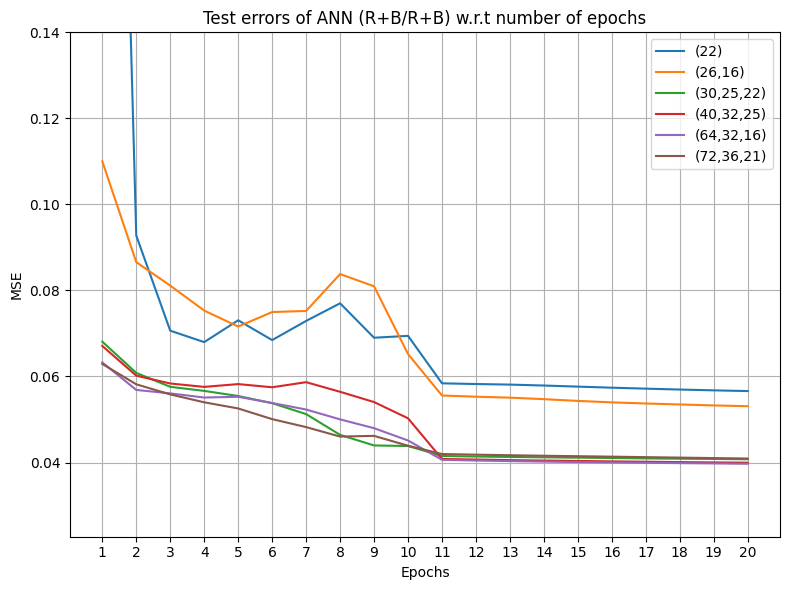

In [131]:
plt.figure(figsize=(8, 6))
# plt.plot(train_losses_1, label=test_losses_1.columns)
plt.plot(test_losses_1, label=test_losses_1.columns)
# Setting y-axis limit
plt.ylim(top=0.14)
# Setting x-axis to show integers only
plt.xticks(np.arange(len(test_losses_1)), np.arange(1, len(test_losses_1)+1))
plt.title('Test errors of ANN (R+B/R+B) w.r.t number of epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

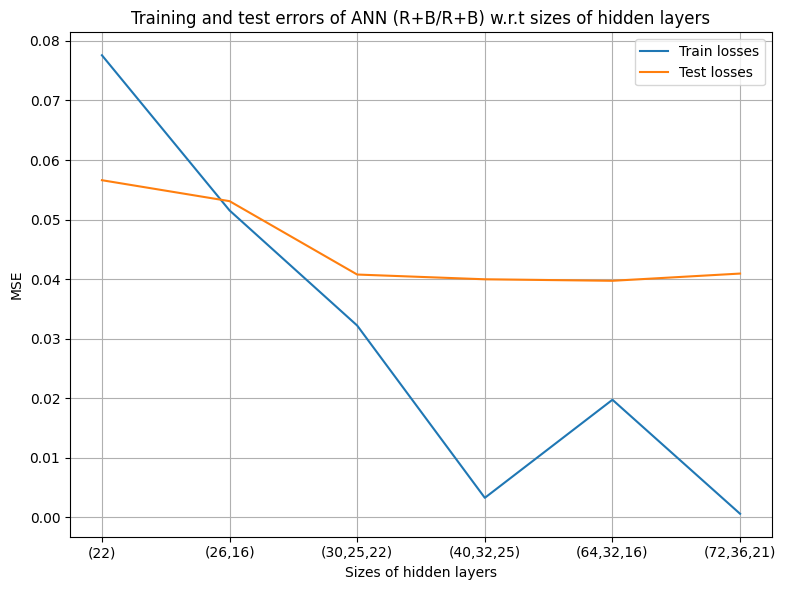

In [102]:
plt.figure(figsize=(8, 6))
plt.plot(test_losses_1.columns,
         train_losses_1.iloc[-1, :], label='Train losses')
plt.plot(test_losses_1.columns, test_losses_1.iloc[-1, :], label='Test losses')

plt.title('Training and test errors of ANN (R+B/R+B) w.r.t sizes of hidden layers')
plt.xlabel('Sizes of hidden layers')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

### Train and test on different datasets

In [103]:
# choose the best network structure according to last picture (test error)
hidden_sizes = [30, 25, 22]

In [104]:
train_losses_2 = []
test_losses_2 = []
models = []
for i in range(len(training_sets)):
    print(f'Training for {combination_name[i]}')

    model = ANNModel(input_size, hidden_sizes, output_size).to(device)

    X_train = training_sets[i][:, :-1].to(device)
    Y_train = training_sets[i][:, -1].to(device)
    X_test = test_sets[i][:, :-1].to(device)
    Y_test = test_sets[i][:, -1].to(device)

    # Create dataloaders for training and test sets
    train_loader = DataLoader(dataset=TensorDataset(
        X_train, Y_train), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=TensorDataset(
        X_test, Y_test), batch_size=batch_size, shuffle=False)

    # Set the parameters for training and evaluating
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(
        optimizer, step_size=lr_decay_step_size, gamma=lr_decay_gamma)

    # Initialize early stopping
    # early_stopping = EarlyStopping(patience=5, min_delta=0.001)

    # Training
    train_losses, test_losses = train(model, train_loader, test_loader, criterion,
                                      optimizer, scheduler, num_epochs=num_epochs)

    train_losses_2.append(train_losses)
    test_losses_2.append(test_losses)
    models.append(model)

Training for R/R
Epoch [1/20], MSE (train): 0.05894
Epoch [1/20], MSE (val): 0.053457
Epoch [2/20], MSE (train): 0.049394
Epoch [2/20], MSE (val): 0.045371
Epoch [3/20], MSE (train): 0.045906
Epoch [3/20], MSE (val): 0.042784
Epoch [4/20], MSE (train): 0.04534
Epoch [4/20], MSE (val): 0.042066
Epoch [5/20], MSE (train): 0.045851
Epoch [5/20], MSE (val): 0.04111
Epoch [6/20], MSE (train): 0.044974
Epoch [6/20], MSE (val): 0.040052
Epoch [7/20], MSE (train): 0.045465
Epoch [7/20], MSE (val): 0.039313
Epoch [8/20], MSE (train): 0.045415
Epoch [8/20], MSE (val): 0.039079
Epoch [9/20], MSE (train): 0.045296
Epoch [9/20], MSE (val): 0.038607
Epoch [10/20], MSE (train): 0.043912
Epoch [10/20], MSE (val): 0.037503
Epoch [11/20], MSE (train): 0.039304
Epoch [11/20], MSE (val): 0.03599
Epoch [12/20], MSE (train): 0.0393
Epoch [12/20], MSE (val): 0.035867
Epoch [13/20], MSE (train): 0.039134
Epoch [13/20], MSE (val): 0.035738
Epoch [14/20], MSE (train): 0.039098
Epoch [14/20], MSE (val): 0.035634

### Save train and test losses

In [105]:
train_losses_2 = pd.DataFrame(
    np.array(train_losses_2).T, columns=combination_name)
train_losses_2

,R/R,B/B,R/B,B/R,R+B/R,R+B/B,R+B/R+B
0,0.058940,0.119872,0.052803,0.103823,0.047651,0.050382,0.041826
1,0.049394,0.076247,0.048712,0.067816,0.036283,0.037237,0.033787
2,0.045906,0.064119,0.047271,0.057255,0.040051,0.038940,0.035469
3,0.045340,0.058377,0.046388,0.051682,0.045768,0.046154,0.059990
4,0.045851,0.054866,0.046030,0.047128,0.030038,0.051164,0.066045
5,0.044974,0.050379,0.046562,0.043540,0.044898,0.061078,0.063838
6,0.045465,0.045428,0.046744,0.041418,0.034105,0.054991,0.049249
7,0.045415,0.041569,0.044133,0.040156,0.019742,0.043211,0.075773
8,0.045296,0.037855,0.045077,0.039160,0.021177,0.041780,0.053232
9,0.043912,0.034020,0.043102,0.038851,0.023892,0.035602,0.042352


In [106]:
test_losses_2 = pd.DataFrame(
    np.array(test_losses_2).T, columns=combination_name)

test_losses_2

,R/R,B/B,R/B,B/R,R+B/R,R+B/B,R+B/R+B
0,0.053457,0.117762,0.144198,0.202824,0.069283,0.105300,0.061245
1,0.045371,0.079147,0.137904,0.169716,0.053979,0.104022,0.056821
2,0.042784,0.065813,0.132698,0.159508,0.051111,0.095546,0.054128
3,0.042066,0.058507,0.128537,0.153107,0.047186,0.089704,0.053479
4,0.041110,0.053431,0.130148,0.152352,0.045597,0.082235,0.050580
5,0.040052,0.049649,0.134100,0.153499,0.042932,0.084563,0.049395
6,0.039313,0.046838,0.134936,0.155146,0.041485,0.081118,0.045488
7,0.039079,0.044888,0.123453,0.156067,0.036570,0.074897,0.047003
8,0.038607,0.043397,0.120475,0.156049,0.035812,0.073298,0.045361
9,0.037503,0.042052,0.125017,0.157635,0.035773,0.073499,0.043919


In [107]:
train_losses_2.to_csv('../outputs/train_losses_wrt_datasets.csv', index=None)
test_losses_2.to_csv('../outputs/test_losses_wrt_datasets.csv', index=None)

### Save the model state

In [108]:
for i in range(len(models)):
    torch.save(models[i].state_dict(), f'../outputs/ann_model_{i}.pth')

### Using the model (R+B/R+B) to predict on test sets of bottleneck and ring

In [109]:
X_B = torch.tensor(test_B[:, : -1], dtype=torch.float32).to(device)
X_R = torch.tensor(test_R[:, : -1], dtype=torch.float32).to(device)

C:\Users\KJ\AppData\Local\Temp\ipykernel_1824\3595534474.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_B = torch.tensor(test_B[:, : -1], dtype=torch.float32).to(device)
C:\Users\KJ\AppData\Local\Temp\ipykernel_1824\3595534474.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_R = torch.tensor(test_R[:, : -1], dtype=torch.float32).to(device)


In [112]:
# Set model to evaluation mode
models[6].eval()

# Forward pass to get predictions
with torch.no_grad():  # Disable gradient tracking
    Y_hat_B = models[6](X_B)
    Y_hat_R = models[6](X_R)

In [113]:
Y_pred_B = Y_hat_B.cpu().numpy()

In [114]:
Y_pred_R = Y_hat_R.cpu().numpy()

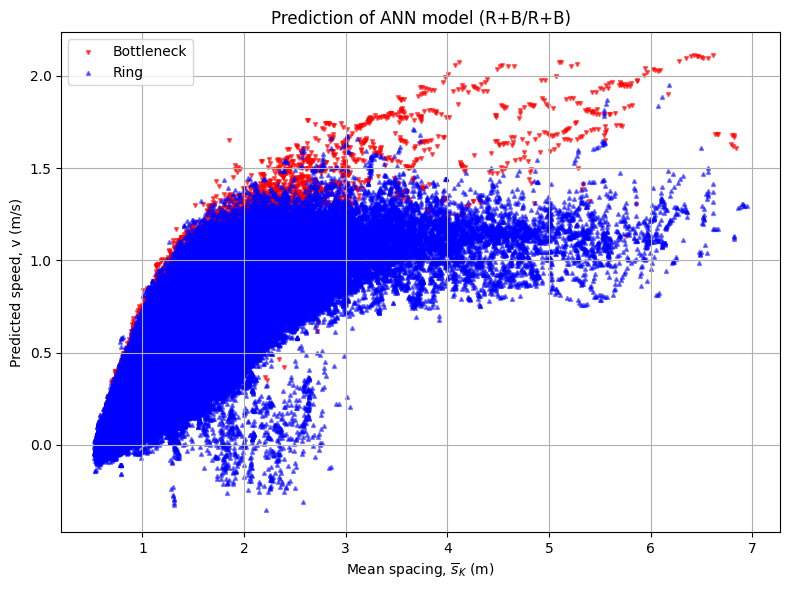

In [115]:
plt.figure(figsize=(8, 6))  # Optional: Set the size of the figure

plt.scatter(test_B[:, 0]/100, Y_pred_B, s=5, c='red',
            alpha=0.6, marker='v', linewidths=1.5, label='Bottleneck')
plt.scatter(test_R[:, 0]/100, Y_pred_R, s=5, c='blue',
            alpha=0.5, marker='^', linewidths=1.5, label='Ring')
# s: size of the points (can be a scalar or an array)
# c: color of the points
# alpha: transparency of the points (0 for transparent, 1 for opaque)
# marker: marker style (e.g., 'o' for circle, 's' for square, etc.)
# edgecolors: color of marker edges
# linewidths: thickness of marker edges

plt.title('Prediction of ANN model (R+B/R+B)')
plt.xlabel('Mean spacing, $\overline{s}_K$ (m)')
plt.ylabel('Predicted speed, v (m/s)')
plt.grid(True)  # Optional: Add gridlines
plt.tight_layout()  # Optional: Adjust layout to prevent clipping of labels
plt.legend()
plt.show()

In [116]:
sk_B = test_B[:, 0]/100
sk_B = sk_B.cpu().numpy()
sk_B, sk_B.shape

(array([0.9656375 , 1.0832088 , 0.89180803, ..., 2.0292525 , 1.9510802 ,
        0.8914876 ], dtype=float32),
 (125669,))

In [117]:
Y_pred_B, Y_pred_B.shape

(array([[0.28467268],
        [0.3282011 ],
        [0.5619303 ],
        ...,
        [1.2154756 ],
        [1.2591333 ],
        [0.46091214]], dtype=float32),
 (125669, 1))

In [118]:
pred_B = np.column_stack((sk_B, Y_pred_B))

# Create a DataFrame
dfB = pd.DataFrame(pred_B, columns=['sk', 'pred'])

# Save to CSV
dfB.to_csv('../outputs/pred_B.csv', index=False)

### Fit 3 parameters in Weidmann model based on the predictions 

In [119]:
from scipy.optimize import curve_fit


# Example data (replace with your actual data)
sk_data = sk_B
v_data = Y_pred_B.reshape(-1,)

# Initial guess for parameters (v0, l, T)
initial_guess = (1.5, 0.6, 0.7)

# Perform curve fitting
params, covariance = curve_fit(
    weidmann_model, sk_data, v_data, p0=initial_guess)

# Extract fitted parameters
v0_fit_B, l_fit_B, T_fit_B = params

# Print fitted parameters
print("Fitted parameters:")
print(f"v0_B = {v0_fit_B}")
print(f"l_B = {l_fit_B}")
print(f"T_B = {T_fit_B}")

Fitted parameters:
v0_B = 1.7008372268144551
l_B = 0.5649512323586183
T_B = 0.840334100805303


In [120]:
sk_R = test_R[:, 0]/100
sk_R = sk_R.cpu().numpy()
sk_R, sk_R.shape

(array([3.3221252, 1.1817596, 1.179584 , ..., 0.9486289, 1.3770136,
        0.6741654], dtype=float32),
 (408861,))

In [121]:
Y_pred_R, Y_pred_R.shape

(array([[0.7179971 ],
        [0.4940685 ],
        [0.57571226],
        ...,
        [0.21853046],
        [0.77057827],
        [0.12917854]], dtype=float32),
 (408861, 1))

In [122]:
pred_R = np.column_stack((sk_R, Y_pred_R))

# Create a DataFrame
dfR = pd.DataFrame(pred_R, columns=['sk', 'pred'])

# Save to CSV
dfR.to_csv('../outputs/pred_R.csv', index=False)

In [123]:
# Example data (replace with your actual data)
sk_data = sk_R
v_data = Y_pred_R.reshape(-1,)

# Initial guess for parameters (v0, l, T)
initial_guess = (1.5, 0.6, 0.7)

# Perform curve fitting
params, covariance = curve_fit(
    weidmann_model, sk_data, v_data, p0=initial_guess)

# Extract fitted parameters
v0_fit_R, l_fit_R, T_fit_R = params

# Print fitted parameters
print("Fitted parameters:")
print(f"v0_R = {v0_fit_R}")
print(f"l_R = {l_fit_R}")
print(f"T_R = {T_fit_R}")

Fitted parameters:
v0_R = 1.1245118378014747
l_R = 0.6034574591004475
T_R = 0.7919258860148987


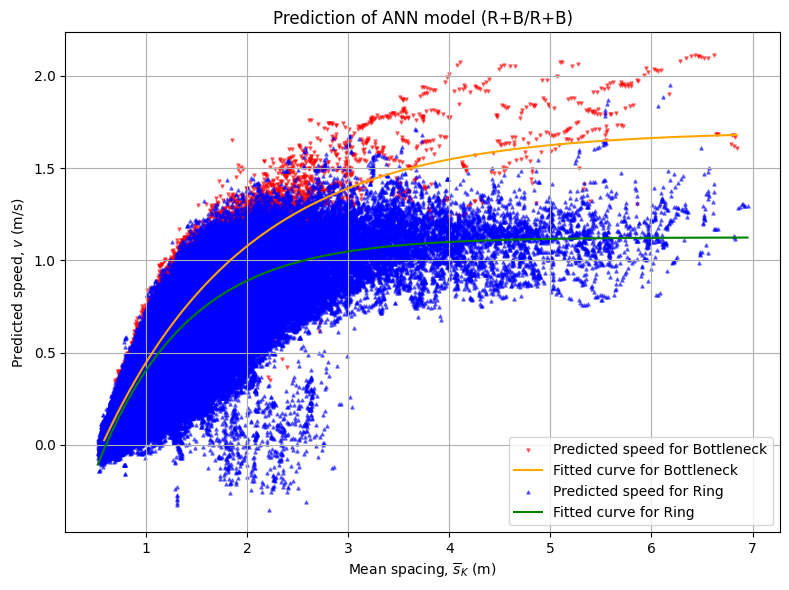

In [124]:
# Generate smooth curve based on fitted parameters
sk_smooth_B = np.linspace(min(sk_B), max(sk_B), 100)
v_smooth_B = weidmann_model(sk_smooth_B, v0_fit_B, l_fit_B, T_fit_B)

sk_smooth_R = np.linspace(min(sk_R), max(sk_R), 100)
v_smooth_R = weidmann_model(sk_smooth_R, v0_fit_R, l_fit_R, T_fit_R)

# Plotting the original data and fitted curve
plt.figure(figsize=(8, 6))
plt.scatter(sk_B, Y_pred_B.reshape(-1,), s=5, c='red', alpha=0.5,
            marker='v', label='Predicted speed for Bottleneck')
plt.plot(sk_smooth_B, v_smooth_B, c='orange',
         alpha=1, label='Fitted curve for Bottleneck')

plt.scatter(sk_R, Y_pred_R.reshape(-1,), s=5, c='blue', alpha=0.5,
            marker='^', label='Predicted speed for Ring')
plt.plot(sk_smooth_R, v_smooth_R, c='green',
         alpha=1, label='Fitted curve for Ring')

plt.title('Prediction of ANN model (R+B/R+B)')
plt.xlabel('Mean spacing, $\overline{s}_K$ (m)')
plt.ylabel('Predicted speed, $v$ (m/s)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()